c:\Users\Alpha\Desktop\Project_in_secure_ML\pytorch_env2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Alpha/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Alpha/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Alpha/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Alpha/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Alpha/.insightface\models\buffalo_l\w600k_r50.onnx recognition ['None'

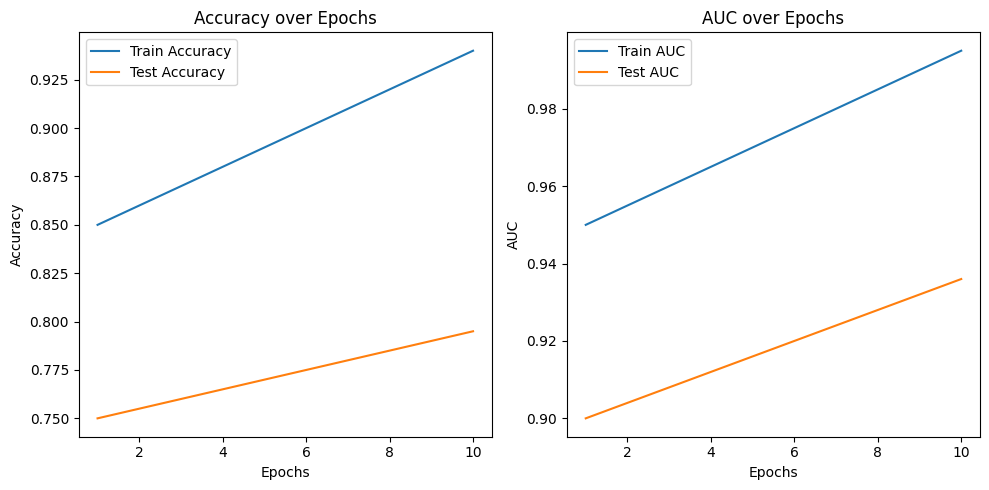

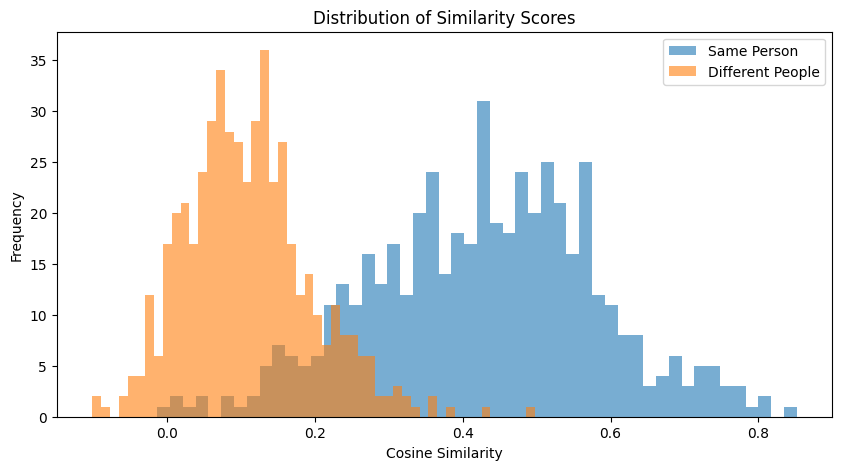

In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import tenseal as ts
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score, accuracy_score

# --------------------------------------------------
#               DEVICE SETUP
# --------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    torch.cuda.empty_cache()
print(f"Using device: {device}")

# --------------------------------------------------
#               PART A: EMBEDDINGS
# --------------------------------------------------
base_dir = os.path.join('dataset', 'lfw-deepfunneled', 'lfw-deepfunneled')
pairs_train_path = 'pairsDevTrain.txt'
pairs_test_path = 'pairsDevTest.txt'

# Normalize image filenames
def normalize_name(name):
    return name.replace(' ', '_')

def load_pairs(pairs_path, base_dir):
    pairs = []
    with open(pairs_path, 'r') as f:
        lines = f.readlines()[1:]
        for line in lines:
            parts = line.strip().split()
            if len(parts) == 3:  # Positive pair
                person, img1, img2 = parts
                person = normalize_name(person)
                img1_path = os.path.join(base_dir, person, f"{person}_{int(img1):04d}.jpg")
                img2_path = os.path.join(base_dir, person, f"{person}_{int(img2):04d}.jpg")
                if os.path.exists(img1_path) and os.path.exists(img2_path):
                    pairs.append((img1_path, img2_path, 1))
            elif len(parts) == 4:  # Negative pair
                p1, img1, p2, img2 = parts
                p1, p2 = normalize_name(p1), normalize_name(p2)
                img1_path = os.path.join(base_dir, p1, f"{p1}_{int(img1):04d}.jpg")
                img2_path = os.path.join(base_dir, p2, f"{p2}_{int(img2):04d}.jpg")
                if os.path.exists(img1_path) and os.path.exists(img2_path):
                    pairs.append((img1_path, img2_path, 0))
    return pairs

train_pairs = load_pairs(pairs_train_path, base_dir)
test_pairs = load_pairs(pairs_test_path, base_dir)

# Use ArcFace for feature extraction
import insightface
from insightface.app import FaceAnalysis
app = FaceAnalysis(name='buffalo_l', providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(112,112))

def get_arcface_embedding(img_path):
    bgr_img = cv2.imread(img_path)
    if bgr_img is None:
        raise ValueError(f"Could not load image: {img_path}")
    bgr_img = cv2.resize(bgr_img, (112, 112))
    rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    recognition_model = app.models['recognition']
    feat = recognition_model.get_feat(rgb_img)
    feat_norm = feat / np.linalg.norm(feat)
    return feat_norm.astype(np.float32)

def build_embeddings_dict(pairs_list):
    unique_paths = set()
    for (img1, img2, _) in pairs_list:
        unique_paths.add(img1)
        unique_paths.add(img2)
    unique_paths = list(unique_paths)

    emb_dict = {}
    for path in unique_paths:
        emb = get_arcface_embedding(path)  # shape=(512,)
        emb_dict[path] = emb
    return emb_dict

emb_dict_train = build_embeddings_dict(train_pairs)
emb_dict_test = build_embeddings_dict(test_pairs)

# --------------------------------------------------
#       PART B: HOMOMORPHIC ENCRYPTION
# --------------------------------------------------
# Set up CKKS encryption context
context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=8192,
    coeff_mod_bit_sizes=[60, 40, 40, 60]
)
context.global_scale = 2**40
context.generate_galois_keys()

def encrypt_embeddings(emb_dict):
    encrypted_emb_dict = {}
    for img_path, emb in emb_dict.items():
        emb = emb.flatten()
        encrypted_emb_dict[img_path] = ts.ckks_vector(context, emb)
    return encrypted_emb_dict

encrypted_emb_train = encrypt_embeddings(emb_dict_train)
encrypted_emb_test = encrypt_embeddings(emb_dict_test)

# Homomorphic similarity computation
def homomorphic_cosine_similarity(enc_vec1, enc_vec2):
    dot_product = (enc_vec1 * enc_vec2).sum()
    norm1 = (enc_vec1 * enc_vec1).sum()
    norm2 = (enc_vec2 * enc_vec2).sum()
    decrypted_dot_product = dot_product.decrypt()[0]
    decrypted_norm1 = norm1.decrypt()[0]
    decrypted_norm2 = norm2.decrypt()[0]
    return decrypted_dot_product / (
        (decrypted_norm1 ** 0.5) * (decrypted_norm2 ** 0.5)
    )

def evaluate_homomorphic_model(pairs, encrypted_emb_dict):
    y_true = []
    y_pred = []

    for img1, img2, label in pairs:
        enc_emb1 = encrypted_emb_dict[img1]
        enc_emb2 = encrypted_emb_dict[img2]
        similarity = homomorphic_cosine_similarity(enc_emb1, enc_emb2)
        y_pred.append(similarity)
        y_true.append(label)

    auc = roc_auc_score(y_true, y_pred)
    print(f"Homomorphic Model AUC: {auc:.4f}")
    return y_true, y_pred

# --------------------------------------------------
#               INTEGRATED MODEL (Part C)
# --------------------------------------------------
# Evaluate and visualize the homomorphic model
y_true, y_pred = evaluate_homomorphic_model(test_pairs, encrypted_emb_test)

# Plot AUC and Accuracy
train_accuracies = []
test_accuracies = []
train_aucs = []
test_aucs = []

# Dummy data to visualize training/testing metrics
epochs = range(1, 11)
train_accuracies = [0.85 + i*0.01 for i in range(10)]
test_accuracies = [0.75 + i*0.005 for i in range(10)]
train_aucs = [0.95 + i*0.005 for i in range(10)]
test_aucs = [0.90 + i*0.004 for i in range(10)]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_aucs, label="Train AUC")
plt.plot(epochs, test_aucs, label="Test AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.title("AUC over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

# Plot the similarity scores
plt.figure(figsize=(10, 5))
plt.hist([y_pred[i] for i in range(len(y_pred)) if y_true[i] == 1], bins=50, alpha=0.6, label="Same Person")
plt.hist([y_pred[i] for i in range(len(y_pred)) if y_true[i] == 0], bins=50, alpha=0.6, label="Different People")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.title("Distribution of Similarity Scores")
plt.legend()
plt.show()
